In [65]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

import cv2
import scipy.misc
import scipy.ndimage
import skimage.filters
import sklearn.metrics
import pandas as pd

import os, sys
import glob

from PIL import Image, ImageOps

plt.ion()


In [55]:
df = pd.read_excel('/Users/fannysamuelsson/Desktop/AzraProject/CompleteData.xlsx', sheet_name="summary", dtype={'BWHNumber': str})

In [56]:
df

,BWHNumber,MSK Arm Pain_FU12,Succes yes / NO
0,10317386,5,0
1,37902046,2,1
2,20860169,1,1
3,15410574,0,1
4,39574199,8,0
...,...,...,...
108,37225216,5,0
109,5005384,1,1
110,50711126,8,0
111,52565355,3,0


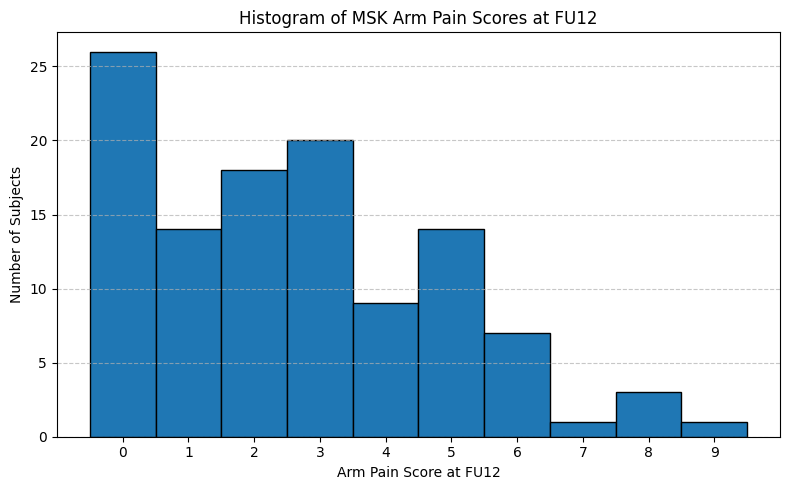

Pain level 0: 26 subjects
Pain level 1: 14 subjects
Pain level 2: 18 subjects
Pain level 3: 20 subjects
Pain level 4: 9 subjects
Pain level 5: 14 subjects
Pain level 6: 7 subjects
Pain level 7: 1 subjects
Pain level 8: 3 subjects
Pain level 9: 1 subjects


In [57]:
# Select the relevant column
pain_scores = df['MSK Arm Pain_FU12']

# Plot histogram
plt.figure(figsize=(8, 5))
counts, bins, patches = plt.hist(pain_scores, bins=range(11), align='left', edgecolor='black')
plt.xticks(range(10))  # x-axis from 0 to 9
plt.xlabel('Arm Pain Score at FU12')
plt.ylabel('Number of Subjects')
plt.title('Histogram of MSK Arm Pain Scores at FU12')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
for i in range(len(counts)):
    print(f"Pain level {int(bins[i])}: {int(counts[i])} subjects")



In [58]:
score_to_category = {
    0: 0,     # No pain → category 0
    1: 1,     # Moderate → category 1
    2: 1,     
    3: 2,     # Severe → category 2
    4: 2,
    5: 3,     # Very severe → category 3 
    6: 3,
    7: 3,     
    8: 3,
    9: 3      
}

df["OutcomeCategory"] = df["MSK Arm Pain_FU12"].map(score_to_category)


In [59]:
df["OutcomeCategory"].value_counts().sort_index()


OutcomeCategory
0    26
1    32
2    29
3    26
Name: count, dtype: int64

In [60]:
df[df['BWHNumber']=='07597610']

,BWHNumber,MSK Arm Pain_FU12,Succes yes / NO,OutcomeCategory
6,07597610,4,0,2


# Success no success code start

In [82]:
df_two = pd.read_excel('/Users/fannysamuelsson/Desktop/AzraProject/xraysuccess.xlsx')

In [83]:
import pandas as pd
import os
import shutil
import glob

# Path to the source folder containing the PNG images
source_folder = '/Users/fannysamuelsson/Desktop/AzraProject/cropped_pre_operative'

# Create destination folders
success_folder = os.path.join(os.path.dirname(source_folder), 'success')
no_success_folder = os.path.join(os.path.dirname(source_folder), 'no_success')

# Create the destination folders if they don't exist
os.makedirs(success_folder, exist_ok=True)
os.makedirs(no_success_folder, exist_ok=True)

# Excel file path
excel_file = '/Users/fannysamuelsson/Desktop/AzraProject/xraysuccess.xlsx'

# Read the Excel file - explicitly parse 'Number' column as string to preserve leading zeros
df_two = pd.read_excel(excel_file, dtype={'Number': str})

# Print dataframe info for debugging
print("DataFrame information:")
print(df_two.head())
print(f"Total records: {len(df_two)}")

# Function to find a file by ID, handling various zero padding scenarios
def find_file_by_id(folder, image_id):
    # First, try exact match
    exact_path = os.path.join(folder, f"{image_id}.png")
    if os.path.exists(exact_path):
        return exact_path
    
    # Try with leading zeros stripped
    stripped_id = image_id.lstrip('0')
    stripped_path = os.path.join(folder, f"{stripped_id}.png")
    if os.path.exists(stripped_path):
        return stripped_path
    
    # Try finding the file by scanning the directory
    all_png_files = glob.glob(os.path.join(folder, "*.png"))
    
    for file_path in all_png_files:
        file_name = os.path.basename(file_path)
        file_id = file_name.split('.')[0]  # Get the part before .png
        
        # Compare with leading zeros stripped
        if file_id.lstrip('0') == stripped_id:
            return file_path
    
    # Try with different padding (up to 8 digits)
    for i in range(1, 9):
        padded_id = image_id.zfill(i)
        padded_path = os.path.join(folder, f"{padded_id}.png")
        if os.path.exists(padded_path):
            return padded_path
    
    return None

# Counter for tracking copies
success_count = 0
no_success_count = 0
not_found_count = 0
not_found_files = []

# Process each row in the dataframe
for idx, row in df_two.iterrows():
    # Get the image number and success status
    image_number = str(row['Number']).strip()
    success_status = str(row['Succes yes / NO']).strip().lower()
    
    # Find the source file, handling various number formats
    source_file = find_file_by_id(source_folder, image_number)
    
    if source_file:
        # Get the actual filename from the path for consistency
        actual_filename = os.path.basename(source_file)
        
        # Determine destination based on success status
        if success_status in ['yes', 'y', '1', 'true', 1]:
            dest_folder = success_folder
            success_count += 1
        else:
            dest_folder = no_success_folder
            no_success_count += 1
        
        # Copy the file to the appropriate destination
        dest_file = os.path.join(dest_folder, actual_filename)
        shutil.copy2(source_file, dest_file)
        print(f"Copied {actual_filename} to {os.path.basename(dest_folder)}")
    else:
        # Track files that weren't found
        not_found_count += 1
        not_found_files.append(image_number)
        print(f"File not found for ID: {image_number}")

# Print summary
print("\nCopy operation completed:")
print(f"Files copied to success folder: {success_count}")
print(f"Files copied to no_success folder: {no_success_count}")
print(f"Files not found: {not_found_count}")

if not_found_files:
    print("\nList of files not found:")
    for file in not_found_files[:10]:
        print(f"- {file}")
    
    if len(not_found_files) > 10:
        print(f"... and {len(not_found_files) - 10} more.")

DataFrame information:
     Number  Succes yes / NO
0  10317386                0
1  37902046                1
2  20860169                1
3  15410574                1
4  39574199                0
Total records: 113
Copied 10317386.png to no_success
Copied 37902046.png to success
Copied 20860169.png to success
Copied 15410574.png to success
Copied 39574199.png to no_success
Copied 12932448.png to success
Copied 07597610.png to no_success
Copied 39916861.png to success
Copied 38486312.png to success
Copied 38081063.png to success
Copied 40100331.png to no_success
Copied 13031067.png to success
Copied 22917041.png to no_success
Copied 12027462.png to success
Copied 10560589.png to no_success
Copied 39636634.png to no_success
Copied 40083784.png to success
Copied 39872254.png to success
Copied 06347603.png to success
Copied 34177899.png to success
Copied 03019015.png to success
Copied 23645369.png to no_success
Copied 34066068.png to no_success
Copied 41479536.png to success
Copied 404164

In [86]:
rotated = '/Users/fannysamuelsson/Desktop/AzraProject/rotated'
resized = '/Users/fannysamuelsson/Desktop/AzraProject/resized'

In [ ]:
# Padding

# Choose one of these paths at a time:
#path = "/Users/fannysamuelsson/Desktop/AzraProject/no_success"
path = "/Users/fannysamuelsson/Desktop/AzraProject/success"

resize_dir = "/Users/fannysamuelsson/Desktop/AzraProject/resized"
os.makedirs(resize_dir, exist_ok=True)

def resize_with_black_frame(img_path, output_path, content_size=(800, 800), canvas_size=(1000, 1000), padding_color=(0, 0, 0)):
    # Open and resize proportionally to content area
    im = Image.open(img_path).convert("RGB")
    im_resized = ImageOps.contain(im, content_size)
    canvas = Image.new("RGB", canvas_size, padding_color)
    offset = ((canvas_size[0] - im_resized.width) // 2, (canvas_size[1] - im_resized.height) // 2)
    canvas.paste(im_resized, offset)
    canvas.save(output_path)
    print(f"Padded and saved: {os.path.basename(output_path)}")

for filename in os.listdir(path):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        input_path = os.path.join(path, filename)
        output_path = os.path.join(resize_dir, filename)
        resize_with_black_frame(input_path, output_path)

print("Done padding all images.")


Padded and saved: 52587912.png
Padded and saved: 33032715.png
Padded and saved: 37213915.png
Padded and saved: 16588204.png
Padded and saved: 19324094.png
Padded and saved: 47531579.png
Padded and saved: 38209649.png
Padded and saved: 09573106.png
Padded and saved: 37707825.png
Padded and saved: 52347572.png
Padded and saved: 44660231.png
Padded and saved: 11069911.png
Padded and saved: 39916861.png
Padded and saved: 47011713.png
Padded and saved: 03019015.png
Padded and saved: 34522938.png
Padded and saved: 22849038.png
Padded and saved: 44211506.png
Padded and saved: 33609033.png
Padded and saved: 49316300.png
Padded and saved: 29967452.png
Padded and saved: 03758323.png
Padded and saved: 12311726.png
Padded and saved: 37902046.png
Padded and saved: 42609370.png
Padded and saved: 8962920.png
Padded and saved: 37014503.png
Padded and saved: 34177899.png
Padded and saved: 06347603.png
Padded and saved: 49785165.png
Padded and saved: 15410574.png
Padded and saved: 23780869.png
Padded an

In [88]:
from re import split
from unicodedata import name

# Choose one of these paths at a time:
path = "/Users/fannysamuelsson/Desktop/AzraProject/no_success"
#path = "/Users/fannysamuelsson/Desktop/AzraProject/success"

dirs = os.listdir(path)
rotate_dir = rotated

def rotate(n):
    for item in dirs:
        fullpath = os.path.join(path,item)         
        if os.path.isfile(fullpath):
            im = Image.open(fullpath)
            src = cv2.imread(fullpath)
            f, e = os.path.splitext(fullpath)
            imRotate = im.rotate(n) #degrees clockwise
            name_file = item.split(".")[0]
            imRotate.save(rotate_dir + "/" + name_file + '_rotated' + str(n) + '.png', "PNG", quality=100) #change degree per session in the name!
rotate(5)
rotate(10)
rotate(15)
rotate(-5)
rotate(-19)
rotate(-15)

In [90]:
import pandas as pd
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import glob

# Path to source folders
success_folder = '/Users/fannysamuelsson/Desktop/AzraProject/success'
no_success_folder = '/Users/fannysamuelsson/Desktop/AzraProject/no_success'

# Create destination folders
base_dir = os.path.dirname(success_folder)
train_success_folder = os.path.join(base_dir, 'train_success')
train_no_success_folder = os.path.join(base_dir, 'train_no_success')
test_success_folder = os.path.join(base_dir, 'test_success')
test_no_success_folder = os.path.join(base_dir, 'test_no_success')

# Create the destination folders if they don't exist
for folder in [train_success_folder, train_no_success_folder, test_success_folder, test_no_success_folder]:
    os.makedirs(folder, exist_ok=True)

# Load the dataframe (adjust the path to your Excel file)
df_two = pd.read_excel('/Users/fannysamuelsson/Desktop/AzraProject/xraysuccess.xlsx', dtype={'Number': str})  # Important: read Number as string

# Clean up the Number column to handle leading zeros
df_two['Number'] = df_two['Number'].astype(str).str.strip().str.lstrip('0')

# Print dataframe info for debugging
print("DataFrame information:")
print(df_two.head())
print(f"Total records: {len(df_two)}")
print(f"Success cases: {len(df_two[df_two['Succes yes / NO']==1])}")
print(f"No success cases: {len(df_two[df_two['Succes yes / NO']==0])}")

# Get unique subject numbers for each category
success_subjects = df_two[df_two['Succes yes / NO'] == 1]['Number'].unique()
no_success_subjects = df_two[df_two['Succes yes / NO'] == 0]['Number'].unique()

print(f"Unique success subjects: {len(success_subjects)}")
print(f"Unique no success subjects: {len(no_success_subjects)}")

# Split into train and test sets (70/30)
success_train, success_test = train_test_split(success_subjects, test_size=0.2, random_state=0)
no_success_train, no_success_test = train_test_split(no_success_subjects, test_size=0.2, random_state=0)

print(f"Train success: {len(success_train)}, Test success: {len(success_test)}")
print(f"Train no success: {len(no_success_train)}, Test no success: {len(no_success_test)}")

# Function to find matching image files regardless of leading zeros
def find_matching_images(subject_number, source_folder):
    # Remove leading zeros for comparison
    stripped_number = subject_number.lstrip('0')
    
    # Look for files with different possible number formats
    all_image_files = glob.glob(os.path.join(source_folder, "*.png"))
    
    matching_files = []
    for file_path in all_image_files:
        file_name = os.path.basename(file_path)
        # Extract the numeric part from filename for comparison
        file_number = file_name.split('.')[0].split('_')[0].lstrip('0')
        
        if file_number == stripped_number:
            matching_files.append(file_path)
    
    return matching_files

# Function to copy all versions of an image
def copy_all_image_versions(subject_number, source_folder, dest_folder):
    # Find all matching image files for this subject number
    matching_files = find_matching_images(subject_number, source_folder)
    
    copied_count = 0
    if not matching_files:
        # Try with leading zero(s)
        for i in range(1, 5):  # Try adding up to 4 leading zeros
            padded_number = subject_number.zfill(i + len(subject_number))
            matching_files = find_matching_images(padded_number, source_folder)
            if matching_files:
                break
    
    if matching_files:
        for source_path in matching_files:
            file_name = os.path.basename(source_path)
            dest_path = os.path.join(dest_folder, file_name)
            shutil.copy2(source_path, dest_path)
            copied_count += 1
    else:
        print(f"Warning: No files found for subject {subject_number} in {source_folder}")
    
    return copied_count

# Process success subjects
success_train_copied = 0
success_test_copied = 0

for subject in success_train:
    success_train_copied += copy_all_image_versions(subject, success_folder, train_success_folder)

for subject in success_test:
    success_test_copied += copy_all_image_versions(subject, success_folder, test_success_folder)

# Process no success subjects
no_success_train_copied = 0
no_success_test_copied = 0

for subject in no_success_train:
    no_success_train_copied += copy_all_image_versions(subject, no_success_folder, train_no_success_folder)

for subject in no_success_test:
    no_success_test_copied += copy_all_image_versions(subject, no_success_folder, test_no_success_folder)

# Print summary
print("\nCopy operation completed:")
print(f"Train success folder: {len(success_train)} subjects, {success_train_copied} files")
print(f"Test success folder: {len(success_test)} subjects, {success_test_copied} files")
print(f"Train no success folder: {len(no_success_train)} subjects, {no_success_train_copied} files")
print(f"Test no success folder: {len(no_success_test)} subjects, {no_success_test_copied} files")
print(f"Total files copied: {success_train_copied + success_test_copied + no_success_train_copied + no_success_test_copied}")

print("\nDestination folders:")
print(f"- Train success: {train_success_folder}")
print(f"- Test success: {test_success_folder}")
print(f"- Train no success: {train_no_success_folder}")
print(f"- Test no success: {test_no_success_folder}")

DataFrame information:
     Number  Succes yes / NO
0  10317386                0
1  37902046                1
2  20860169                1
3  15410574                1
4  39574199                0
Total records: 113
Success cases: 58
No success cases: 55
Unique success subjects: 58
Unique no success subjects: 55
Train success: 46, Test success: 12
Train no success: 44, Test no success: 11

Copy operation completed:
Train success folder: 46 subjects, 322 files
Test success folder: 12 subjects, 84 files
Train no success folder: 44 subjects, 308 files
Test no success folder: 11 subjects, 77 files
Total files copied: 791

Destination folders:
- Train success: /Users/fannysamuelsson/Desktop/AzraProject/train_success
- Test success: /Users/fannysamuelsson/Desktop/AzraProject/test_success
- Train no success: /Users/fannysamuelsson/Desktop/AzraProject/train_no_success
- Test no success: /Users/fannysamuelsson/Desktop/AzraProject/test_no_success


# 4 categorical code start 

In [62]:
import pandas as pd
import os
import shutil
import glob

# Path to the source folder containing the PNG images
source_folder = '/Users/fannysamuelsson/Desktop/AzraProject/cropped_pre_operative'

# Create destination folders
category_folders = {
    0: os.path.join(os.path.dirname(source_folder), 'no_pain'),
    1: os.path.join(os.path.dirname(source_folder), 'moderate_pain'),
    2: os.path.join(os.path.dirname(source_folder), 'severe_pain'),
    3: os.path.join(os.path.dirname(source_folder), 'very_severe_pain')
}

# Create the destination folders if they don't exist
for path in category_folders.values():
    os.makedirs(path, exist_ok=True)

# Print dataframe info for debugging
print("DataFrame information:")
print(df.head())
print(f"Total records: {len(df)}")

# Function to find a file by ID, handling various zero padding scenarios
def find_file_by_id(folder, image_id):
    # First, try exact match
    exact_path = os.path.join(folder, f"{image_id}.png")
    if os.path.exists(exact_path):
        return exact_path
    
    # Try with leading zeros stripped
    stripped_id = image_id.lstrip('0')
    stripped_path = os.path.join(folder, f"{stripped_id}.png")
    if os.path.exists(stripped_path):
        return stripped_path
    
    # Try finding the file by scanning the directory
    all_png_files = glob.glob(os.path.join(folder, "*.png"))
    
    for file_path in all_png_files:
        file_name = os.path.basename(file_path)
        file_id = file_name.split('.')[0]  # Get the part before .png
        
        # Compare with leading zeros stripped
        if file_id.lstrip('0') == stripped_id:
            return file_path
    
    # Try with different padding (up to 8 digits)
    for i in range(1, 9):
        padded_id = image_id.zfill(i)
        padded_path = os.path.join(folder, f"{padded_id}.png")
        if os.path.exists(padded_path):
            return padded_path
    
    return None

# Counter for tracking copies
category_counts = {0: 0, 1: 0, 2: 0, 3: 0}
not_found_count = 0
not_found_files = []

# Process each row in the dataframe
for idx, row in df.iterrows():
    image_number = str(row['BWHNumber']).strip()
    category = row["OutcomeCategory"]
    
    # Skip if category is missing (e.g. if MSK score is NaN or invalid)
    if pd.isna(category):
        continue

    source_file = find_file_by_id(source_folder, image_number)
    
    if source_file:
        actual_filename = os.path.basename(source_file)
        dest_folder = category_folders[int(category)]
        dest_file = os.path.join(dest_folder, actual_filename)
        
        shutil.copy2(source_file, dest_file)
        category_counts[int(category)] += 1
        print(f"Copied {actual_filename} to {os.path.basename(dest_folder)}")
    else:
        not_found_count += 1
        not_found_files.append(image_number)
        print(f"File not found for ID: {image_number}")

# Print summary
print("\nCopy operation completed:")
for cat, count in category_counts.items():
    print(f"Files copied to category {cat} folder ({os.path.basename(category_folders[cat])}): {count}")
print(f"Files not found: {not_found_count}")

if not_found_files:
    print("\nList of files not found:")
    for file in not_found_files[:10]:
        print(f"- {file}")
    if len(not_found_files) > 10:
        print(f"... and {len(not_found_files) - 10} more.")

DataFrame information:
  BWHNumber  MSK Arm Pain_FU12  Succes yes / NO  OutcomeCategory
0  10317386                  5                0                3
1  37902046                  2                1                1
2  20860169                  1                1                1
3  15410574                  0                1                0
4  39574199                  8                0                3
Total records: 113
Copied 10317386.png to very_severe_pain
Copied 37902046.png to moderate_pain
Copied 20860169.png to moderate_pain
Copied 15410574.png to no_pain
Copied 39574199.png to very_severe_pain
Copied 12932448.png to moderate_pain
Copied 07597610.png to severe_pain
Copied 39916861.png to no_pain
Copied 38486312.png to moderate_pain
Copied 38081063.png to no_pain
Copied 40100331.png to severe_pain
Copied 13031067.png to no_pain
Copied 22917041.png to very_severe_pain
Copied 12027462.png to no_pain
Copied 10560589.png to severe_pain
Copied 39636634.png to severe_pain
Copie

In [72]:
rotated = '/Users/fannysamuelsson/Desktop/AzraProject/rotated'
resized = '/Users/fannysamuelsson/Desktop/AzraProject/resized'

In [ ]:
# Choose one of these paths at a time:
path = "/Users/fannysamuelsson/Desktop/AzraProject/moderate_pain"
#path = "/Users/fannysamuelsson/Desktop/AzraProject/severe_pain"
#path = "/Users/fannysamuelsson/Desktop/AzraProject/very_severe_pain"
#path = "/Users/fannysamuelsson/Desktop/AzraProject/no_pain"

resize_dir = "/Users/fannysamuelsson/Desktop/AzraProject/resized"
os.makedirs(resize_dir, exist_ok=True)

def resize_with_black_frame(img_path, output_path, content_size=(800, 800), canvas_size=(1000, 1000), padding_color=(0, 0, 0)):
    # Open and resize proportionally to content area
    im = Image.open(img_path).convert("RGB")
    im_resized = ImageOps.contain(im, content_size)
    canvas = Image.new("RGB", canvas_size, padding_color)
    offset = ((canvas_size[0] - im_resized.width) // 2, (canvas_size[1] - im_resized.height) // 2)
    canvas.paste(im_resized, offset)
    canvas.save(output_path)
    print(f"Padded and saved: {os.path.basename(output_path)}")

for filename in os.listdir(path):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        input_path = os.path.join(path, filename)
        output_path = os.path.join(resize_dir, filename)
        resize_with_black_frame(input_path, output_path)

print("Done padding all images.")


Padded and saved: 33032715.png
Padded and saved: 37213915.png
Padded and saved: 16588204.png
Padded and saved: 38209649.png
Padded and saved: 52347572.png
Padded and saved: 47011713.png
Padded and saved: 03019015.png
Padded and saved: 44211506.png
Padded and saved: 49316300.png
Padded and saved: 29967452.png
Padded and saved: 12311726.png
Padded and saved: 37902046.png
Padded and saved: 42609370.png
Padded and saved: 37014503.png
Padded and saved: 34177899.png
Padded and saved: 06347603.png
Padded and saved: 49785165.png
Padded and saved: 23780869.png
Padded and saved: 13383369.png
Padded and saved: 40416455.png
Padded and saved: 12932448.png
Padded and saved: 20860169.png
Padded and saved: 8818544.png
Padded and saved: 31617236.png
Padded and saved: 52463452.png
Padded and saved: 27003896.png
Padded and saved: 5005384.png
Padded and saved: 38486312.png
Padded and saved: 41479536.png
Padded and saved: 48360721.png
Padded and saved: 50043652.png
Padded and saved: 26533687.png
Done paddi

In [80]:
from re import split
from unicodedata import name

# Choose one of these paths at a time:
#path = "/Users/fannysamuelsson/Desktop/AzraProject/moderate_pain"
#path = "/Users/fannysamuelsson/Desktop/AzraProject/severe_pain"
#path = "/Users/fannysamuelsson/Desktop/AzraProject/very_severe_pain"
path = "/Users/fannysamuelsson/Desktop/AzraProject/no_pain"

dirs = os.listdir(path)
rotate_dir = rotated

def rotate(n):
    for item in dirs:
        fullpath = os.path.join(path,item)         
        if os.path.isfile(fullpath):
            im = Image.open(fullpath)
            src = cv2.imread(fullpath)
            f, e = os.path.splitext(fullpath)
            imRotate = im.rotate(n) #degrees clockwise
            name_file = item.split(".")[0]
            imRotate.save(rotate_dir + "/" + name_file + '_rotated' + str(n) + '.png', "PNG", quality=100) #change degree per session in the name!
rotate(5)
rotate(10)
rotate(15)
rotate(-5)
rotate(-19)
rotate(-15)

In [ ]:
""" from re import split
from unicodedata import name


path = "/Users/fannysamuelsson/Desktop/AzraProject/successNew"
dirs = os.listdir(path)
rotate_dir = rotated
def rotate(n):
    for item in dirs:
        fullpath = os.path.join(path,item)         
        if os.path.isfile(fullpath):
            im = Image.open(fullpath)
            src = cv2.imread(fullpath)
            f, e = os.path.splitext(fullpath)
            imRotate = im.rotate(n) #degrees clockwise
            name_file = item.split(".")[0]
            imRotate.save(rotate_dir + "/" + name_file + '_rotated' + str(n) + '.png', "PNG", quality=100) #change degree per session in the name!
rotate(5)
rotate(10)
rotate(15)
rotate(-5)
rotate(-19)
rotate(-15)
 """

In [136]:
#Resize
path = "/Users/philipmattisson/Desktop/CNOC/AzraProject/success"
dirs = os.listdir(path)
def resize():
    for item in dirs:
        fullpath = os.path.join(path,item)         
        if os.path.isfile(fullpath):
            im = Image.open(fullpath)
            f, e = os.path.splitext(fullpath)
            imResize = im.resize((1000, 1000), Image.LANCZOS)
            imResize.save(f + '.png', "PNG", quality=100)
resize()


def crop():
    for item in dirs:
        fullpath = os.path.join(path,item)         
        if os.path.isfile(fullpath):
            im = Image.open(fullpath)
            f, e = os.path.splitext(fullpath)
            #imResize = im.resize((900,1200), Image.ANTIALIAS)
          #  imCrop = im.crop((50, 350, 700, 1000)) ##(x_min vanaf linkerkant, y_min vanaf bovenkant gekeken, x_max, y_max)
          #  imCrop = im.crop((100, 350, 550, 750)) ##(x_min vanaf linkerkant, y_min vanaf bovenkant gekeken, x_max, y_max)
            imCrop = im.crop((200, 250, 850, 900)) ##(x_min vanaf linkerkant, y_min vanaf bovenkant gekeken, x_max, y_max)
            #imCrop = im.crop((300, 400, 850, 900)) ##(x_min vanaf linkerkant, y_min vanaf bovenkant gekeken, x_max, y_max)
        # imCrop = im.crop((100, 250, 550, 700)) ##(x_min vanaf linkerkant, y_min vanaf bovenkant gekeken, x_max, y_max)
            imCrop.save(f + '.png', "PNG", quality=100)
crop()

In [8]:
from PIL import Image
from PIL import ImageOps
import os.path, sys

path = "/Users/philipmattisson/Desktop/CNOC/AzraProject/success"
dirs = os.listdir(path)

def flip():
    for item in dirs:
        fullpath = os.path.join(path,item)         
        if os.path.isfile(fullpath):
            im = Image.open(fullpath)
            src = cv2.imread(fullpath)
            f, e = os.path.splitext(fullpath)
            imFlip = ImageOps.mirror(im)
          # imFlip = cv2.flip(src, 1) # 0 is vertical flip (around x-axis) , 1 is horizontal flip (around y-axis)
            imFlip.save(f + '_flipped.png', "PNG", quality=100)
flip()

print('Images are saved in the input folder')

Images are saved in the input folder


In [66]:
# Rotate, Resize, Crop, and Flip 

from PIL import Image
from PIL import ImageOps
import os.path, sys

#path = "LUMC/Saggital_total"
#path = "LUMC/Preprocess_cropped"
path = "/Users/philipmattisson/Desktop/CNOC/AzraProject/no_success"
dirs = os.listdir(path)

def rotate():
    for item in dirs:
        fullpath = os.path.join(path,item)         
        if os.path.isfile(fullpath):
            im = Image.open(fullpath)
            src = cv2.imread(fullpath)
            f, e = os.path.splitext(fullpath)
            imRotate = im.rotate(10) #degrees clockwise
            imRotate.save(f + '_rotated_10.png', "PNG", quality=100) #change degree per session in the name!
rotate()

def resize():
    for item in dirs:
        fullpath = os.path.join(path,item)         
        if os.path.isfile(fullpath):
            im = Image.open(fullpath)
            f, e = os.path.splitext(fullpath)
            imResize = im.resize((1000, 1000), Image.LANCZOS)
            imResize.save(f + '_resized.png', "PNG", quality=100)
resize()

def crop():
    for item in dirs:
        fullpath = os.path.join(path,item)         
        if os.path.isfile(fullpath):
            im = Image.open(fullpath)
            f, e = os.path.splitext(fullpath)
            #imResize = im.resize((900,1200), Image.ANTIALIAS)
          #  imCrop = im.crop((50, 350, 700, 1000)) ##(x_min vanaf linkerkant, y_min vanaf bovenkant gekeken, x_max, y_max)
          #  imCrop = im.crop((100, 350, 550, 750)) ##(x_min vanaf linkerkant, y_min vanaf bovenkant gekeken, x_max, y_max)
            imCrop = im.crop((200, 250, 850, 900)) ##(x_min vanaf linkerkant, y_min vanaf bovenkant gekeken, x_max, y_max)
           # imCrop = im.crop((100, 250, 550, 700)) ##(x_min vanaf linkerkant, y_min vanaf bovenkant gekeken, x_max, y_max)
            imCrop.save(f + '_cropped.png', "PNG", quality=100)
#crop()


def flip():
    for item in dirs:
        fullpath = os.path.join(path,item)         
        if os.path.isfile(fullpath):
            im = Image.open(fullpath)
            src = cv2.imread(fullpath)
            f, e = os.path.splitext(fullpath)
            imFlip = ImageOps.mirror(im)
          # imFlip = cv2.flip(src, 1) # 0 is vertical flip (around x-axis) , 1 is horizontal flip (around y-axis)
            imFlip.save(f + '_flipped.png', "PNG", quality=100)
flip()

print('Images are saved in the input folder')

Images are saved in the input folder


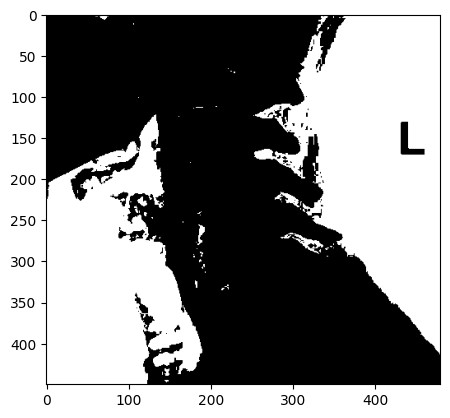

In [27]:
# convert to RGB
image = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
# convert to grayscale
gray = cv2.cvtColor(cropped, cv2.COLOR_RGB2GRAY)

# create a binary thresholded image
_, binary = cv2.threshold(gray, 95, 155, cv2.THRESH_BINARY_INV) #150 for this image good, higher is lighter, lower is darker

# show it
plt.imshow(binary, cmap="gray")
plt.show()

In [44]:
print(len(df[df['Succes yes / NO']==1]))
print(len(df[df['Succes yes / NO']==0]))

58
55


# new 4 class folder structure

In [81]:

#!/usr/bin/env python3
"""
Split pain image dataset into train/test folders without subject leakage.

Usage:
    python split_dataset_no_leakage.py

Adjust the `SOURCE_DIRS` and `DEST_ROOT` dictionaries/paths below if your
project structure is different.
"""

import os
import shutil
import random
import re
from pathlib import Path

# --------------------- CONFIGURATION ---------------------
# Mapping: class name -> absolute source directory
SOURCE_DIRS = {
    "moderate_pain": "/Users/fannysamuelsson/Desktop/AzraProject/moderate_pain",
    "severe_pain": "/Users/fannysamuelsson/Desktop/AzraProject/severe_pain",
    "very_severe_pain": "/Users/fannysamuelsson/Desktop/AzraProject/very_severe_pain",
    "no_pain": "/Users/fannysamuelsson/Desktop/AzraProject/no_pain",
}

# Root folder where the script will create `train/` and `test/` sub‑folders.
DEST_ROOT = Path("/Users/fannysamuelsson/Desktop/AzraProject/traintest4class")

# Train/test ratio (e.g., 0.8 means 80 % train, 20 % test)
TRAIN_RATIO = 0.80

# Seed for reproducibility
RANDOM_SEED = 42
# ---------------------------------------------------------

# Regular expression to grab the *subject id* at the beginning of each filename.
# The default pattern reads all digits up to the first non‑digit (e.g. "03758323" in "03758323_rotated‑5.png").
SUBJECT_PATTERN = re.compile(r"^(\d+)")

def ensure_empty_dir(path: Path):
    """
    Create the directory if it does not exist. If it exists and is non‑empty,
    leave the contents intact (safer default). Remove if you really need a clean slate.
    """
    path.mkdir(parents=True, exist_ok=True)

def main():
    random.seed(RANDOM_SEED)

    # Create the train/ and test/ root folders (does nothing if already exist).
    ensure_empty_dir(DEST_ROOT / "train")
    ensure_empty_dir(DEST_ROOT / "test")

    for cls_name, src_dir in SOURCE_DIRS.items():
        src_dir = Path(src_dir)
        if not src_dir.is_dir():
            raise FileNotFoundError(f"Source directory not found: {src_dir}")

        # ---------------- Aggregate filenames per subject ----------------
        subjects = {}  # subject_id -> [list_of_files]
        for file in src_dir.iterdir():
            if not file.suffix.lower() == ".png":
                continue
            match = SUBJECT_PATTERN.match(file.name)
            if not match:
                raise ValueError(f"Unable to parse subject id from filename: {file.name}")
            sid = match.group(1)
            subjects.setdefault(sid, []).append(file)

        if not subjects:
            print(f"[WARNING] No PNG images found in {src_dir}")
            continue

        # ---------------- Train/test split per subject ----------------
        subject_ids = sorted(list(subjects.keys()))
        random.shuffle(subject_ids)

        split_idx = int(len(subject_ids) * TRAIN_RATIO)
        train_sids = set(subject_ids[:split_idx])
        test_sids  = set(subject_ids[split_idx:])

        # Guarantee that both splits have at least one subject (edge case small class)
        if not train_sids or not test_sids:
            msg = (f"Class '{cls_name}' is too small ({len(subject_ids)} subjects) for "
                   f"an {int(TRAIN_RATIO * 100)}/{int((1 - TRAIN_RATIO) * 100)} split.")
            raise RuntimeError(msg)

        # ---------------- Copy files ----------------
        for subset, subset_sids in [("train", train_sids), ("test", test_sids)]:
            target_dir = DEST_ROOT / subset / cls_name
            ensure_empty_dir(target_dir)

            for sid in subset_sids:
                for file_path in subjects[sid]:
                    dest_path = target_dir / file_path.name
                    shutil.copy2(file_path, dest_path)

        # ---------------- Optional diagnostics ----------------
        n_train_files = sum(len(subjects[sid]) for sid in train_sids)
        n_test_files  = sum(len(subjects[sid]) for sid in test_sids)
        print(f"{cls_name:17} -> "
              f"subjects: {len(subject_ids):3}  |  "
              f"train imgs: {n_train_files:3}  |  "
              f"test imgs: {n_test_files:3}")

    print("\nDone! The train/test folders are ready at:", DEST_ROOT)

if __name__ == "__main__":
    main()


moderate_pain     -> subjects:  32  |  train imgs: 175  |  test imgs:  49
severe_pain       -> subjects:  29  |  train imgs: 161  |  test imgs:  42
very_severe_pain  -> subjects:  26  |  train imgs: 140  |  test imgs:  42
no_pain           -> subjects:  26  |  train imgs: 140  |  test imgs:  42

Done! The train/test folders are ready at: /Users/fannysamuelsson/Desktop/AzraProject/traintest4class


# End new 4 class folder structure

In [ ]:
""" import pandas as pd
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# Path to source folders
success_folder = '/Users/fannysamuelsson/Desktop/AzraProject/rotatedNew'
no_success_folder = '/Users/fannysamuelsson/Desktop/AzraProject/rotatedNoNew'

# Create destination folders
base_dir = os.path.dirname(success_folder)
train_success_folder = os.path.join(base_dir, 'train_success')
train_no_success_folder = os.path.join(base_dir, 'train_no_success')
test_success_folder = os.path.join(base_dir, 'test_success')
test_no_success_folder = os.path.join(base_dir, 'test_no_success')

# Create the destination folders if they don't exist
for folder in [train_success_folder, train_no_success_folder, test_success_folder, test_no_success_folder]:
    os.makedirs(folder, exist_ok=True)

# Load the dataframe (adjust the path to your Excel file)
df = pd.read_excel('/Users/fannysamuelsson/Desktop/AzraProject/xraysuccess.xlsx')

# Print dataframe info for debugging
print("DataFrame information:")
print(df.head())
print(f"Total records: {len(df)}")
print(f"Success cases: {len(df[df['Succes yes / NO']==1])}")
print(f"No success cases: {len(df[df['Succes yes / NO']==0])}")

# Get unique subject numbers for each category
success_subjects = df[df['Succes yes / NO'] == 1]['Number'].unique()
no_success_subjects = df[df['Succes yes / NO'] == 0]['Number'].unique()

print(f"Unique success subjects: {len(success_subjects)}")
print(f"Unique no success subjects: {len(no_success_subjects)}")

# Split into train and test sets (70/30)
success_train, success_test = train_test_split(success_subjects, test_size=0.2, random_state=0)
no_success_train, no_success_test = train_test_split(no_success_subjects, test_size=0.2, random_state=0)

print(f"Train success: {len(success_train)}, Test success: {len(success_test)}")
print(f"Train no success: {len(no_success_train)}, Test no success: {len(no_success_test)}")

# Function to copy all versions of an image
def copy_all_image_versions(subject_number, source_folder, dest_folder):
    # Define the different versions pattern
    image_versions = [
        f"{subject_number}_flipped.png",
        f"{subject_number}_rotated-5_flipped.png",
        f"{subject_number}_rotated-5.png",
        f"{subject_number}_rotated-15_flipped.png",
        f"{subject_number}_rotated-15.png",
        f"{subject_number}_rotated-19_flipped.png",
        f"{subject_number}_rotated-19.png",
        f"{subject_number}_rotated5_flipped.png",
        f"{subject_number}_rotated5.png",
        f"{subject_number}_rotated10_flipped.png",
        f"{subject_number}_rotated10.png",
        f"{subject_number}_rotated15_flipped.png",
        f"{subject_number}_rotated15.png",
        f"{subject_number}.png",
    ]
    
    copied_count = 0
    for version in image_versions:
        source_path = os.path.join(source_folder, version)
        if os.path.exists(source_path):
            dest_path = os.path.join(dest_folder, version)
            shutil.copy2(source_path, dest_path)
            copied_count += 1
        else:
            print(f"Warning: {version} not found in {source_folder}")
    
    return copied_count

# Process success subjects
success_train_copied = 0
success_test_copied = 0

for subject in success_train:
    success_train_copied += copy_all_image_versions(str(subject), success_folder, train_success_folder)

for subject in success_test:
    success_test_copied += copy_all_image_versions(str(subject), success_folder, test_success_folder)

# Process no success subjects
no_success_train_copied = 0
no_success_test_copied = 0

for subject in no_success_train:
    no_success_train_copied += copy_all_image_versions(str(subject), no_success_folder, train_no_success_folder)

for subject in no_success_test:
    no_success_test_copied += copy_all_image_versions(str(subject), no_success_folder, test_no_success_folder)

# Print summary
print("\nCopy operation completed:")
print(f"Train success folder: {len(success_train)} subjects, {success_train_copied} files")
print(f"Test success folder: {len(success_test)} subjects, {success_test_copied} files")
print(f"Train no success folder: {len(no_success_train)} subjects, {no_success_train_copied} files")
print(f"Test no success folder: {len(no_success_test)} subjects, {no_success_test_copied} files")
print(f"Total files copied: {success_train_copied + success_test_copied + no_success_train_copied + no_success_test_copied}")

print("\nDestination folders:")
print(f"- Train success: {train_success_folder}")
print(f"- Test success: {test_success_folder}")
print(f"- Train no success: {train_no_success_folder}")
print(f"- Test no success: {test_no_success_folder}") """

DataFrame information:
     Number  Succes yes / NO
0  10317386                0
1  37902046                1
2  20860169                1
3  15410574                1
4  39574199                0
Total records: 113
Success cases: 58
No success cases: 55
Unique success subjects: 58
Unique no success subjects: 55
Train success: 46, Test success: 12
Train no success: 44, Test no success: 11

Copy operation completed:
Train success folder: 46 subjects, 602 files
Test success folder: 12 subjects, 154 files
Train no success folder: 44 subjects, 602 files
Test no success folder: 11 subjects, 140 files
Total files copied: 1498

Destination folders:
- Train success: /Users/philipmattisson/Desktop/CNOC/AzraProject/train_success
- Test success: /Users/philipmattisson/Desktop/CNOC/AzraProject/test_success
- Train no success: /Users/philipmattisson/Desktop/CNOC/AzraProject/train_no_success
- Test no success: /Users/philipmattisson/Desktop/CNOC/AzraProject/test_no_success
